# COGS 108 - Final Project 

# Overview

Yelp has become infamous among business owners for the open door it offers frustrated consumers who may not have had a representative experience at a facility. But are reviews really so reactive, or is there consistency between the content of a review and its rating? Are some ratings more reliable than others? It can be difficult to process blanket criticism from outsiders, but if Yelp review content had measured correlation with review rating (and therefore, ranking of the business on its site), it might provide guidance to anyone trying to use the reviews to improve the business (or park!). Unfortunately, the sentiment analysis conducted in this investigation did not demonstrate a strong statistical significance.

# Name & GitHub

- Name: Bailey Passmore
- GitHub Username: bailatrix

# Research Question

Is the content of a Yelp review an accurate predictor of the sentiment of its rating? Further, is the prediction quality equal for all 5 rating options, or do some ratings see more reliable predictions than others?

## Background and Prior Work

In past years, I worked for a contractor who was constantly battling his Yelp rating and simply could not figure out how to have a "fair" rating on the site. He tried getting new customers to write reviews, that worked sometimes but a lot of people didn't think it significant. He offered to help customers who didn't have a Yelp account to sign-up or even provide a monetary reward, but he was instructed his business could not involve itself in the review process like that.

In fact, Yelp has a very particular set of rules[1] it expects businesses and organizations on its platform to follow to maintain good standing with consumers. Countless articles and blogs online offer suggests to improve Yelp ratings [2] and recover from bad reviews, but these results are slow to become fruitful and it begs the question, how strong is the link between review sentiment and review rating? If the caliber expected of a business owner could be expected from the consumer writing the review, the review data should contain reliable features to use in predictions.

References (include links):
- [1] https://www.reviewtrackers.com/blog/yelp-factsheet/
- [2] https://www.wordstream.com/blog/ws/2013/07/22/yelp-reviews

# Hypothesis

Review content should be predictive of ratings, at least in the case of lower ratings seeing more accuracy. This could be expected because a more negative experience may standout more than a neutral or generally positive experience might, and this could inform greater detail of review.

# Dataset(s)

- Dataset Name:    `yelp_SD_reviews.csv`
- Number of observations:    2333
- Link to the dataset:    https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_reviews.csv
- Dataset documentation:    https://github.com/COGS108/individual_fa20/blob/master/data/README.md#san-diego-parks-yelp-data

This dataset makes up just over 2,000 Yelp reviews for parks in San Diego, CA, USA. The columns available are:
* `id`:    Subject of the review (the park)
* `rating`:    Rating of review (out of 5 stars)
* `text`:    Text of review (raw)

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/baileyp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/baileyp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
rev_src = '../data/yelp_SD_reviews.csv'

# Data Cleaning

This dataset shows a heavily redacted and anonymized version of the original sample set, so there is nothing more to reduce from the features of the data. In terms of cleanliness, it's still useful to check for null or empty values, but the dataset is in great shape for the tests applied in this investigation.

The vectorizers needed for the next step of text analysis are also prepared in this section. 

In [20]:
rev_df = pd.read_csv( rev_src )
rev_df.isnull().sum()

id        0
rating    0
text      0
dtype: int64

In [21]:
rev_df.shape

(2333, 3)

In [22]:
rev_df.head()

,id,rating,text
0,Balboa Park,5,Balboa Park is a must see when coming to San D...
1,Balboa Park,5,Beautiful grounds even to take a stroll during...
2,Balboa Park,5,Beautiful sightseeing in San Diego. Lots of wa...
3,Civita Park,5,Was invited to child's B-Day party pre Covid-1...
4,Civita Park,5,"Pretty nice park, beautiful design. Anyone is..."


In [5]:
# setup test and training sets according to 80/20 parameter
num_training = int( 0.8 * len(rev_df) ) 
num_testing = int( 0.2 * len(rev_df) )

# setup training function
def train_SVM(X, y, kernel='linear'):
    clf = SVC( kernel=kernel )
    clf = clf.fit( X, y )
    return clf

In [6]:
# vectorizer for BoW
vectorizer = CountVectorizer( analyzer = 'word',
                              max_features = 2000,
                              tokenizer = word_tokenize,
                              stop_words = stopwords.words('english') )

# vectorizer for tf-idf
tfidf = TfidfVectorizer( sublinear_tf = True,
                        analyzer = 'word',
                        max_features = 2000, 
                        tokenizer = word_tokenize )

# Data Analysis & Results

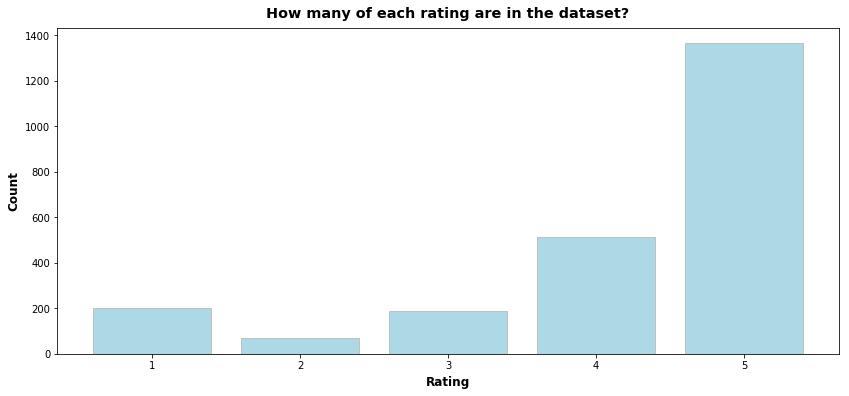

<Figure size 432x288 with 0 Axes>

In [8]:
# format data
rating_count = rev_df.groupby(['rating'])['id'].count()
plt.bar( [1, 2, 3, 4, 5], rating_count, color='lightblue', edgecolor='silver')

# setup labels
plt.xlabel('Rating', labelpad=5, fontweight='bold', fontsize='large')
plt.ylabel('Count', labelpad=5, fontweight='bold', fontsize='large')
plt.title('How many of each rating are in the dataset?', pad=10,
          fontdict={'fontweight': 'bold', 'fontsize': 'x-large'})

# visualization of data
plt.gcf().set_size_inches(14, 6)
plt.show()

# Save figure as .png
plt.savefig( "./rating_freq.png", bbox='tight')

Given that 5-star ratings make up a majority of the data, the predictions from these reviews would hold the most practical significance, if any. We may be able to get reasonable inferences from 1-, 3-, and 4-star reviews from the sample size, but it would be much less likely to have any practical meaning.

Now, separately apply each of the vectorizers and print out the results from the Bag of Words (BoW) and Term Frequency - Inverse Document Frequency (Tf-Idf) classification on the train and test sets.

BoW classification standardizes sentiment between the words of a sentence and their frequency within the sentence, whereas Tf-Idf considers the frequency of those same words against the whole body of reviews, potentially informing us as to whether reviews with more distinctive patterns predict rating differently than the standard BoW classifier does.

In [9]:
# prepare respective X and Y data
rev_X = vectorizer.fit_transform( rev_df["text"] ).toarray()
rev_y = rev_df["rating"].values

# collect subsets of X and Y data according to train/test parameters
rev_train_X = rev_X[ : num_training ] 
rev_train_y = rev_y[  : num_training ]
rev_test_X = rev_X[ num_training : ]
rev_test_y = rev_y[ num_training : ]

# setup classifier and predictions
rev_clf = train_SVM( rev_train_X, rev_train_y )
rev_predicted_train_y = rev_clf.predict( rev_train_X )
rev_predicted_test_y = rev_clf.predict( rev_test_X )

# display classifier reports - BoW
print("Bag of Words (BoW) prediction:\n1) Train, 2) Test\n")
print(classification_report(rev_train_y, rev_predicted_train_y))
print(classification_report(rev_test_y, rev_predicted_test_y))

Bag of Words (BoW) prediction:
1) Train, 2) Test

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       158
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00       144
           4       1.00      0.97      0.99       424
           5       0.99      1.00      1.00      1091

    accuracy                           0.99      1866
   macro avg       1.00      0.99      1.00      1866
weighted avg       0.99      0.99      0.99      1866

              precision    recall  f1-score   support

           1       0.29      0.28      0.29        43
           2       0.08      0.05      0.06        22
           3       0.14      0.12      0.13        42
           4       0.20      0.18      0.19        87
           5       0.67      0.73      0.70       273

    accuracy                           0.50       467
   macro avg       0.28      0.27      0.27       467
weighted avg       0.47    

While the BoW classifier had a training accuracy of 99%, the test set was not accurate at all, dropping down to 50%.

In [10]:
# prepare X data as tfidf vector
rev_tfidf_X = tfidf.fit_transform( rev_df['text'].values ).toarray()

# collect subsets of X and Y data according to train/test parameters
rev_train_tfidf_X = rev_tfidf_X[ : num_training ]
rev_train_tfidf_y = rev_y[ : num_training ]
rev_test_tfidf_X = rev_tfidf_X[ num_training : ]
rev_test_tfidf_y = rev_y[ num_training : ]

# setup classifier and predictions
rev_tfidf_clf = train_SVM( rev_train_tfidf_X, rev_train_tfidf_y )
rev_pred_train_tfidf_y = rev_tfidf_clf.predict( rev_train_tfidf_X )
rev_pred_test_tfidf_y = rev_tfidf_clf.predict( rev_test_tfidf_X )

# display classifier reports - TfIdf
print("Term Frequency - Inverse Document Frequency (Tf-Idf) prediction:\n1) Train, 2) Test\n")
print(classification_report(rev_train_tfidf_y, rev_pred_train_tfidf_y))
print(classification_report(rev_test_tfidf_y, rev_pred_test_tfidf_y))

Term Frequency - Inverse Document Frequency (Tf-Idf) prediction:
1) Train, 2) Test

              precision    recall  f1-score   support

           1       0.98      0.61      0.75       158
           2       0.00      0.00      0.00        49
           3       1.00      0.19      0.32       144
           4       0.81      0.58      0.68       424
           5       0.75      0.98      0.85      1091

    accuracy                           0.77      1866
   macro avg       0.71      0.47      0.52      1866
weighted avg       0.78      0.77      0.74      1866

              precision    recall  f1-score   support

           1       0.50      0.09      0.16        43
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        42
           4       0.30      0.10      0.15        87
           5       0.61      0.95      0.74       273

    accuracy                           0.58       467
   macro avg       0.28      0.23      0.21    

The tf-idf classifier had a lower training accuracy at 77%, but while the variance in training-to-test accuracy was lesser, so was the accuracy itself, coming down to 58% for test set.

# Ethics & Privacy

Yelp reviews on its site include a consumer's name, Yelp standing, as well as their photo and potential other personal information. These categories of data were left out of the dataset used in this investigation because they are not relevant to potential analysis and therefore should be left anonymous. It's still possible that the text of a review contains personal information, but because we observe the data at this degree of anonymity and because the text data is processed by vectorizers and not human analysis, this is can be considered negligible.

It terms of the ethics of conducting this investigation, it could be useful to the business owners and community organizers receiving (and occasionally battling) these Yelp ratings to know how reasonable the correlation between review content and review rating is in practice. On the other hand, demonstrating a lack of correlation between these could ultimately undermine the consumer's review and/or the Yelp rating system. 

# Conclusion & Discussion

It does not appear that review content is a true predictor of a Yelp review's rating on its 5-star scale, or that any particular rating sees more accurate predictions than another. The 5-star rating in particular did see mid-high range performance in both train/test sets for both BoW and Tf-Idf, but it still did not meet the threshold for signficance. The hypothesis suggested lower ratings would be more accurate and this was not able to be addressed by the dataset or the analysis applied.

This dataset was restricted by its original parameters in that it only included the Yelp reviews of parks in San Diego, which is not necessarily a large population or a common practice when visiting a park. The ratings were scattered and few for each park, although the dominant rating observed was the 5-star. Had there been anything statistically significant observed in this investigation, it would still need to be shown that this dataset could have practical significance outside of the realm of parks in San Diego.